In [1]:
import basedosdados as bd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import plotly
import plotnine
import geopandas as gpd




## Query 1

In [167]:
df = bd.read_sql(
    '''
    WITH sim AS(
    SELECT
    sigla_uf,
    CASE
        WHEN sexo = '1' THEN "Masculino"
        WHEN sexo = '2' THEN "Feminino"
        ELSE NULL
    END AS sexo_fator,
    CASE
        WHEN raca_cor = '1' THEN "Branca"
        WHEN raca_cor = '2' THEN "Preta"
        WHEN raca_cor = '3' THEN "Amarela"
        WHEN raca_cor = '4' THEN "Parda"
        WHEN raca_cor = '5' THEN "Indígena"
        ELSE NULL
    END AS raca_fator,
    CASE
        WHEN idade < 18 THEN "Menor de 18 anos"
        WHEN idade BETWEEN 18 AND 30 THEN "Entre 18 e 30 anos"
        WHEN idade BETWEEN 30 AND 50 THEN "Entre 30 e 50 anos"
        ELSE "Maior que 50 anos"
    END AS idade_fator,
    SUM(numero_obitos) as total_obitos
    FROM `basedosdados.br_ms_sim.municipio_causa_idade_sexo_raca`
    WHERE (causa_basica LIKE 'T60%'
        OR causa_basica LIKE 'X48%'
        OR causa_basica LIKE 'X68%'
        OR causa_basica LIKE 'X87%'
        OR causa_basica LIKE 'Y18%'
        OR causa_basica LIKE 'Z574') AND ano > 2009
    GROUP BY sigla_uf, sexo, idade_fator, raca_cor
    ORDER BY total_obitos DESC
    ),

    diretorios AS(
    SELECT * 
    FROM `basedosdados.br_bd_diretorios_brasil.uf` 

    ),
    pop AS(
    SELECT * 
    FROM `basedosdados.br_ibge_populacao.uf` 
    WHERE ano = 2017

    )
    SELECT t1.*, t2.*, t3.*
    FROM sim t1
    LEFT JOIN diretorios t2
        ON t1.sigla_uf = t2.sigla
    LEFT JOIN pop t3
        ON t2.sigla = t3.sigla_uf
    ORDER BY t1.total_obitos DESC
    ''', 
    billing_project_id = 'casebd'
)

Downloading: 100%|██████████| 580/580 [00:00<00:00, 964.43rows/s]


In [170]:
df[["regiao", "total_obitos"]].groupby("regiao").sum()
df[["total_obitos"]].sum()


total_obitos    6368
dtype: int64

In [158]:
df_temp = df.groupby(["regiao","sexo_fator", "raca_fator", "idade_fator"]).sum().reset_index()
df_temp1 = df_temp[["regiao","sexo_fator", "raca_fator", "idade_fator", "total_obitos"]]

In [159]:
df_temp1.groupby("sexo_fator").sum()

,total_obitos
sexo_fator,
Feminino,2058
Masculino,4069


In [58]:
df_teste = df_temp1[["regiao", "idade_fator", "total_obitos"]].rename({'regiao': 'source', 'idade_fator': 'target', 'total_obitos':'value'}, axis = 1)
df_teste.dtypes

source    object
target    object
value      Int64
dtype: object

In [160]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    colorPalette = ['#000000','#B81D1D','#000000','#B81D1D','#000000']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    labelList = list(dict.fromkeys(labelList))
    
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 1
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count'],
          color = "#0000004A"
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig


### Gráfico 1

In [166]:
fig = genSankey(df,cat_cols=["regiao", "sexo_fator","raca_fator", "idade_fator"],value_cols='total_obitos',
title="Perfil das mortes causadas por agrotóxicos e inseticidas no Brasil, no período 2009-2019 <br> Fonte: Sistema de Informações sobre Mortalidade (SIM) via @basedosdados ·  Elaboração: Arthur Gusmão <br>")
plotly.offline.plot(fig, validate=False)

'temp-plot.html'

## Query 2 

In [3]:
from plotnine import *


In [15]:
df3 = bd.read_sql(
    '''
    WITH sim AS(
    SELECT
    sigla_uf, ano,
    SUM(numero_obitos) as total_obitos
    FROM `basedosdados.br_ms_sim.municipio_causa` 
    WHERE (causa_basica LIKE 'T60%'
        OR causa_basica LIKE 'X48%'
        OR causa_basica LIKE 'X68%'
        OR causa_basica LIKE 'X87%'
        OR causa_basica LIKE 'Y18%'
        OR causa_basica LIKE 'Z574') AND ano > 2008
    GROUP BY sigla_uf, ano
    ORDER BY total_obitos DESC
    ),
    diretorios AS(
    SELECT nome, regiao, id_uf, sigla
    FROM `basedosdados.br_bd_diretorios_brasil.uf` 

    ),
    pop AS(
    SELECT * 
    FROM `basedosdados.br_ibge_populacao.uf` 
    WHERE ano > 2009

    )

    SELECT t1.*, t2.*, t3.*
    FROM sim t1
    LEFT JOIN diretorios t2
        ON t1.sigla_uf = t2.sigla
    LEFT JOIN pop t3
        ON t2.sigla = t3.sigla_uf AND t1.ano = t3.ano
    ORDER BY t1.total_obitos DESC
    ''', 
    billing_project_id = 'casebd'
)

Downloading: 100%|██████████| 280/280 [00:00<00:00, 491.08rows/s]


In [18]:
df3["obitos_100"] = (df3["total_obitos"]/df3["populacao"]) * 100000


In [86]:
df_plot = df3.groupby(["regiao", "ano"])["total_obitos"].sum().reset_index()
df_plot['ano'] = pd.to_datetime(df_plot['ano'], format='%Y')
df_plot['total_obitos'] = np.floor(pd.to_numeric(df_plot['total_obitos'], errors='coerce')).astype('Float64')



### Gráfico 2

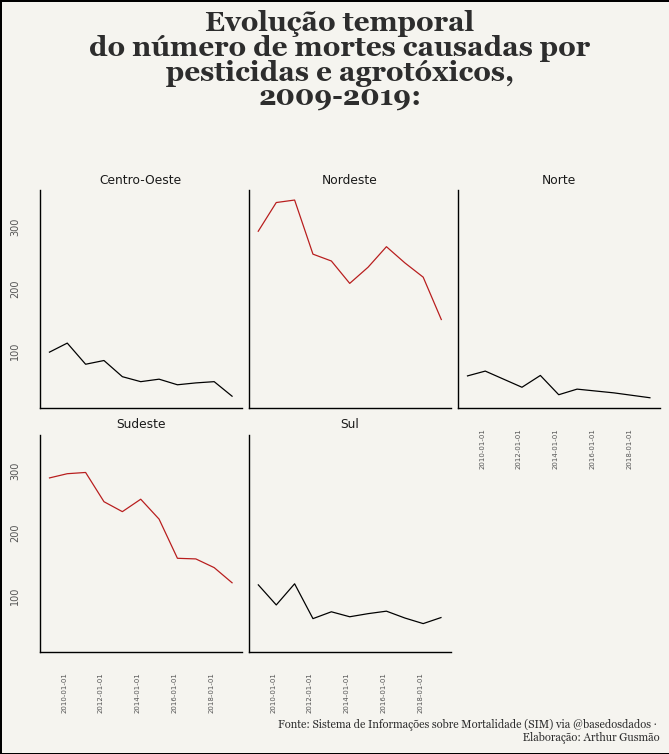

<ggplot: (337295092)>

In [153]:
(
    ggplot(df_plot, aes(x='ano', y='total_obitos', color = 'regiao'))
    + geom_line()
    + facet_wrap('regiao')
    + scale_color_manual(values=['#000000','#B81D1D','#000000','#B81D1D','#000000'])
    + theme_minimal()
    + theme(figure_size=(8, 6), legend_title= element_blank())
    + labs(
    title = "Evolução temporal\ndo número de mortes causadas por\npesticidas e agrotóxicos,\n2009-2019:",
    caption = "Fonte: Sistema de Informações sobre Mortalidade (SIM) via @basedosdados · \n Elaboração: Arthur Gusmão", x = ""
  )
    + theme(panel_background=element_rect(fill = "#F5F4EF"),               # new
            axis_title_y=element_blank(),
            axis_line_x=element_line(color='black'),
            axis_line_y=element_line(),
            axis_text_y=element_text(color = ccolor, angle = 90, size = 7),
            axis_text_x=element_text(color=ccolor, angle = 90, vjust = 1, hjust=1, size = 5),
            axis_ticks_major_y=element_blank(),
            panel_grid=element_blank(),
            panel_border=element_blank(),
            legend_position= "none",
            plot_background= element_rect(fill = "#F5F4EF"),
            plot_caption=element_text(size = 8, family = "Georgia", color = "#2D2D2D"),
            plot_title= (element_text(
                                      size = 20,
                                      family = "Georgia",
                                      face = "bold",
                                      vjust = 0, 
                                      color = "#2D2D2D"
    )) )
)